In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve

In [ ]:
# We will use random forests algoritm to estimate propability of situation, that employee leave the job
# We will base of data of his satisfaction from work (satisfaction_level), satisfaction in previous year (last_evaluation),
# number of project that he was involved in (number_project), how logh he work in month (average_montly_hours),
# how many years he work in company (time_spend_company), if he had an accident in work (Work_accident),
# if he had been promoted in 5 years (promotion_last_5years), his department (sales) and level of his salary (salary)

In [2]:
# Data download
# You shoud put your own path, where you saved HR.txt file on your computer
df_o = pd.read_csv('C:/Users/Lenovo/Desktop/machine_learning./HR.txt')
# Exploratory Data Analysis is in report.html file


In [3]:
target = "left"
numFeatures = ['satisfaction_level', 'last_evaluation', 'number_project','average_montly_hours', 'time_spend_company', 'Work_accident']
catFeatures = [ 'promotion_last_5years', 'sales', 'salary']

# Copying of the object
df = df_o.copy()
# Dictionary of maps
mapy = {}
for feature in catFeatures:
    # Object that will contain map
    le = preprocessing.LabelEncoder()
    # Adjustment of column (map making)
    df[feature] = le.fit_transform(df_o[feature])
    # saving map
    mapy[feature] = le
    
features = df.columns.tolist()
features.remove(target)

In [4]:
# cross-validation wrapper
def CVTestRFClass(nFolds = 5, randomState=21347, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Lists for results:
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    precision = []
    recall = []

    # Loop over folds
    for train, test in kf.split(df.index.values):
        # estimator
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
    
        # Training the model
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Forecast for treining and test sets
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # saving prediction for this fold
        predictions.append(preds.tolist().copy())
        
        # Saving indexes
        indices.append(df.iloc[test].index.tolist().copy())

        
        # Calculation of model fit for a ROC-AUC metric for propability of leaving
        trainScore = roc_auc_score((df[target].iloc[train]==1).astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1).astype(int), preds)
        predsBinary = preds.copy()
        
        # Calculating of precision and recall for clasification with selected threshold
        threshold = 0.5
        predsBinary[predsBinary>=threshold] = 1
        predsBinary[predsBinary<threshold] = 0
        
        testPrecisionScore = precision_score((df[target].iloc[test]==1).astype(int), predsBinary)
        testRecallScore = recall_score((df[target].iloc[test]==1).astype(int), predsBinary)
        
        # Seving the results
        trainResults.append(trainScore)
        testResults.append(testScore)
        precision.append(testPrecisionScore)
        recall.append(testRecallScore)
        # Information about fitting in each fold
        if debug:
            print("Train AUC:", round(trainScore, 4),
                    "Valid AUC:", round(testScore, 4))
        
    return trainResults, testResults, predictions, indices, precision, recall, clf

In [5]:
# Hyperparameters
# We will search for optimal values of hyperparameters

# Loop over n_estimators
for k in [10, 25, 50, 100, 200, 500, 1000]:
    trainResults, testResults, predictions, indices, precision, recall, clfRF = CVTestRFClass(n_estimators=k)
    print(k, np.round(np.mean(trainResults), 4), np.round(np.mean(testResults), 4), np.round(np.mean(trainResults) - np.mean(testResults), 4))

# max_depth
for k in range(2, 22, 2):
    trainResults, testResults, predictions, indices, precision, recall, clfRF = CVTestRFClass(n_estimators=100, max_depth=k)
    print(k, np.round(np.mean(trainResults), 4), np.round(np.mean(testResults), 4), np.round(np.mean(trainResults) - np.mean(testResults), 4))

# min_sample_split
for k in range(2, 10):
    trainResults, testResults, predictions, indices, precision, recall, clfRF = CVTestRFClass(n_estimators=100, max_depth=10, min_samples_split=k)
    print(k, np.round(np.mean(trainResults), 4), np.round(np.mean(testResults), 4), np.round(np.mean(trainResults) - np.mean(testResults), 4))

# max_features
for k in range(2, 10):
    trainResults, testResults, predictions, indices, precision, recall, clfRF = CVTestRFClass(n_estimators=100, max_depth=10,max_features=k, min_samples_split=5)
    print(k, np.round(np.mean(trainResults), 4), np.round(np.mean(testResults), 4), np.round(np.mean(trainResults) - np.mean(testResults), 4))

# max_features
for k in range(1, 5):
    trainResults, testResults, predictions, indices, precision, recall, clfRF = CVTestRFClass(n_estimators=100, max_depth=10,max_features=3, min_samples_split=5, min_samples_leaf=k)
    print(k, np.round(np.mean(trainResults), 4), np.round(np.mean(testResults), 4), np.round(np.mean(trainResults) - np.mean(testResults), 4))

10 1.0 0.9901 0.0099
25 1.0 0.9919 0.0081
50 1.0 0.9928 0.0072
100 1.0 0.9926 0.0074
200 1.0 0.9932 0.0068
500 1.0 0.9932 0.0068
1000 1.0 0.9933 0.0067
2 0.9379 0.9377 0.0002
4 0.98 0.9794 0.0006
6 0.9879 0.9843 0.0036
8 0.9953 0.9897 0.0056
10 0.999 0.9925 0.0065
12 0.9998 0.9927 0.0071
14 0.9999 0.9937 0.0063
16 1.0 0.9931 0.0069
18 1.0 0.993 0.007
20 1.0 0.9931 0.0069
2 0.999 0.9925 0.0065
3 0.9988 0.9925 0.0063
4 0.9987 0.9925 0.0061
5 0.9987 0.9929 0.0057
6 0.9984 0.9924 0.006
7 0.9984 0.9919 0.0065
8 0.9983 0.9918 0.0065
9 0.9982 0.9918 0.0064
2 0.9976 0.9914 0.0062
3 0.9987 0.9929 0.0057
4 0.9988 0.992 0.0068
5 0.9987 0.9922 0.0065
6 0.9984 0.9919 0.0065
7 0.9981 0.9916 0.0065
8 0.9975 0.9909 0.0066
9 0.9971 0.9901 0.007
1 0.9987 0.9929 0.0057
2 0.9984 0.9921 0.0064
3 0.9982 0.992 0.0062
4 0.9979 0.992 0.0059


In [6]:
# Training and saving model with best hyperparameters
trainResults, testResults, predictions, indices, precision, recall, clfRF = CVTestRFClass(n_estimators=200, max_depth=14, max_features=3, min_samples_split=5, min_samples_leaf=1)
print("mean Valid AUC: ", np.round(np.mean(testResults),4))

modelRF = {
    "name":"RF",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=200, max_depth=14, max_features=3, min_samples_split=5, min_samples_leaf=1',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "model": clfRF,
}

mean Valid AUC:  0.9934


In [7]:
# Plotting function
def plotROCs(results):

    # Size
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in results:
        # Calculating the points needed to draw the ROC curve
        # The roc_curve function returns three data series, fpr, tpr and the cut-off levels
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Calculate the Area Under the Curve
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)
    
        # Curve thickness
        lw = 2

        # Plotting the ROC curve
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Drawing a 45 degree curve as a reference point
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # margins
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

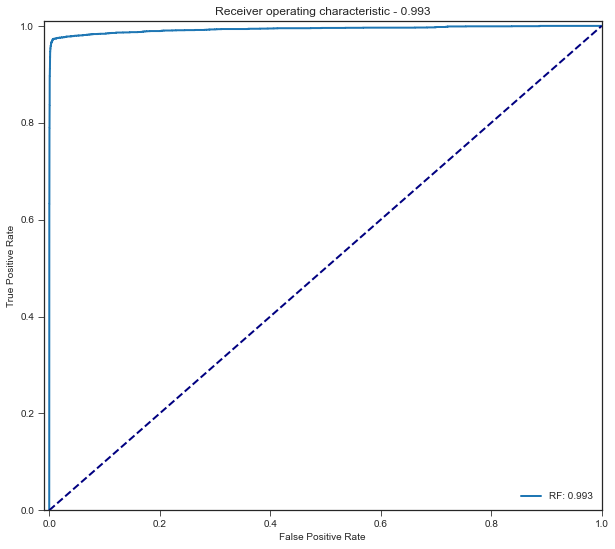

In [8]:
res2plot = []
true = (df[target]==1).astype(int).sort_index()
for result in [modelRF]:
    # Creating a prediction vector by creating a pandas series and then sorting the index
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Plotting
plotROCs(res2plot)

In [90]:
# The model looks OK

In [9]:
# Precision and recall
print("precision", np.mean(precision))
print("recall", np.mean(recall))

precision 0.9943970001064104
recall 0.9446489016553112


In [83]:
# model in use
# Lets check the propability of leaving the exemplary person

In [84]:
# Firstly, lets check what we need to know about employee:
features

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years',
 'sales',
 'salary']

In [85]:
#Lets remind the possible states of the department of employee and his salary

In [86]:
print(mapy['sales'].classes_)
print(mapy['salary'].classes_)

['IT' 'RandD' 'accounting' 'hr' 'management' 'marketing' 'product_mng'
 'sales' 'support' 'technical']
['high' 'low' 'medium']


In [87]:
#Lets consider person, that have 0.45 in satisfaction level, 0.51 in previous evaluation of satisfaction, 
# worked in 2 projecs, worked 160 hours, spent 3 years in company, had accident in work, not promated in 5 years,
# been working in technical department and have medium salary

In [88]:
# Show the codes of technical department and medium salary
print(mapy['sales'].transform(['technical']))
print(mapy['salary'].transform(['medium']))

[9]
[2]


In [89]:
# Lets put all values and codes of the features in the model and print the answer
likelihood_of_dismissal = clfRF.predict_proba([[0.45,0.51,2,160,3,1,0,9,2]])[:,1]
print(likelihood_of_dismissal)

[0.97247378]
